In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

from gait_modulation import MatFileReader, DataProcessor, Visualise, FeatureExtractor
from gait_modulation import BaseModel, RegressionModel, LSTMModel
from gait_modulation.utils.utils import split_data, load_config

In [2]:
lfp_metadata_config = load_config('gait_modulation/configs/written/lfp_metadata_config.yaml')

sfreq = lfp_metadata_config['LFP_METADATA']['lfp_sfreq']

In [3]:
time_continuous_uniform = np.load('processed/features/time_continuous_uniform-feat.npz')['times_uniform']
time_continuous_uniform.shape

(16, 6, 38213)

In [4]:
time_continuous_uniform[0,0,0]

-7.8700388611

# Linear Regression

In [5]:
# Parameters for prediction
# future_steps = [1, 10, 100]  # Prediction horizons in samples

time_horizons_ms = [4, 20, 42]  # Future horizons in milliseconds
time_horizons_samples = [int(ms * sfreq / 1000) for ms in time_horizons_ms]
time_horizons_samples

[1, 5, 10]

In [6]:
# Reshape data for trials x channels x times to 2D (samples x features)
n_trials, n_channels, n_times = time_continuous_uniform.shape


# Reshape to (trials * times, channels)
reshaped_flat_time = FeatureExtractor.reshape_lfp_data(
    time_continuous_uniform,mode="flat_time")
reshaped_flat_time.shape

# # Reshape to (trials, times * channels)
# reshaped_flat_channel = FeatureExtractor.reshape_lfp_data(
#     time_continuous_uniform, mode="flat_channel")
# reshaped_flat_channel.shape

def create_lagged_data(data, lag):
    """
    Create lagged dataset for time series prediction.
    
    Parameters:
    - data: Input data array of shape (samples, features)
    - lag: Number of time steps to predict into the future
    
    Returns:
    - X: Input features of shape (samples - lag, features)
    - y: Target values of shape (samples - lag, features)
    """
    X = data[:-lag]
    y = data[lag:]
    return X, y

X, y = create_lagged_data(reshaped_flat_time, time_horizons_samples[2])
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (611398, 6)
y shape: (611398, 6)


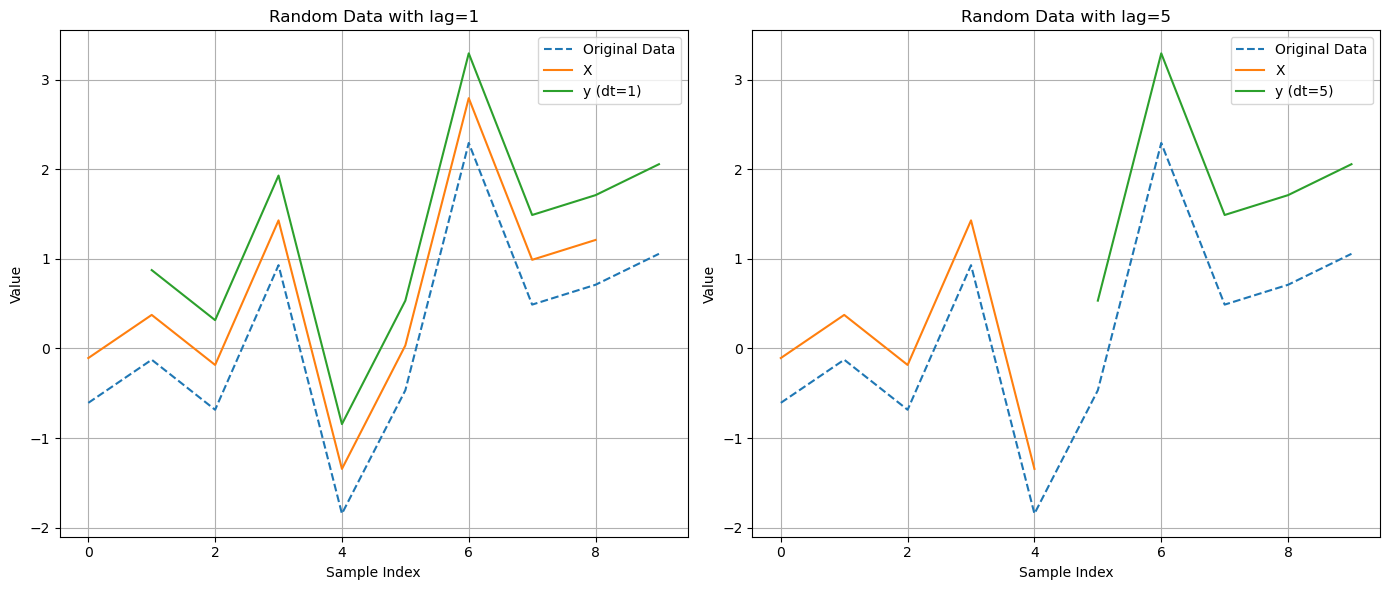

In [7]:
np.random.seed(40)
random_data = np.random.randn(10)
dt = [1, 5]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for i, d in enumerate(dt):
    axs[i].plot(random_data, '--', label="Original Data")
    axs[i].plot(np.arange(0, len(random_data)-d), random_data[:-d]+0.5, label="X")
    axs[i].plot(np.arange(d, len(random_data)), random_data[d:]+1, label=f"y (dt={d})")
    axs[i].set_title(f"Random Data with lag={d}")
    axs[i].set_xlabel("Sample Index")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [42]:
# Define a set of models to evaluate
models = {
    "linear_regression": LinearRegression(),
    "ridge_regression": Ridge(alpha=0.5),
    "lasso_regression": Lasso(alpha=0.1)
}

# Define K-Fold Cross Validator
kf = KFold(n_splits=5)  # Number of splits (folds)

# Initialize a dictionary to store the results
results = {model_name: [] for model_name in models.keys()}
all_predictions = {model_name: {} for model_name in models.keys()}
best_models = {model_name: None for model_name in models.keys()}
best_scores = {model_name: float('inf') for model_name in models.keys()}
best_predictions = {model_name: {} for model_name in models.keys()}

# Loop over each prediction horizon
for future_step in time_horizons_samples:
    print(f"\n### Predicting {future_step} samples ({future_step / sfreq * 1000} ms) into the future ###")
    
    # Create lagged dataset for the current prediction horizon
    X, y = create_lagged_data(reshaped_flat_time, future_step)
    
    # Evaluate each model using K-Fold Cross Validation
    for model_name, model in models.items():
        print(f"\n{model_name} - Prediction Horizon: {future_step} samples ({future_step / sfreq * 1000} ms)")
        fold_mse = []  # Store MSE for each fold
        all_predictions[model_name][future_step] = {}  # Initialize dictionary for current horizon
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Fit the model
            model.fit(X_train, y_train)
            
            # Predict the test set
            y_pred = model.predict(X_test)
            
            # Evaluate performance using Mean Squared Error (MSE)
            mse = mean_squared_error(y_test, y_pred)
            fold_mse.append(mse)
            print(f"{model_name} - Fold {fold} MSE: {mse:.4f}")
            
            # Store the true and predicted values for the current fold
            all_predictions[model_name][future_step][fold] = np.array([y_test, y_pred])
        
        # Store the average MSE for the current model and prediction horizon
        avg_mse = np.mean(fold_mse)
        results[model_name].append(avg_mse)
        
        # Update the best model if the current model has a better score
        if avg_mse < best_scores[model_name]:
            best_scores[model_name] = avg_mse
            best_models[model_name] = model
            best_predictions[model_name][future_step] = all_predictions[model_name][future_step]

# Compare the performance of different models
for model_name, mse_values in results.items():
    print(f"\n### {model_name} ###")
    for future_step, mse in zip(time_horizons_samples, mse_values):
        print(f"{future_step} samples ({future_step / sfreq * 1000} ms): Average MSE = {mse:.4f}")

# Select the best model for each prediction horizon
for future_step in time_horizons_samples:
    best_model = min(results, key=lambda model_name: results[model_name][time_horizons_samples.index(future_step)])
    print(f"\nBest model for {future_step} samples ({future_step / sfreq * 1000} ms): {best_model}")

# Print the best models and their scores
print("\nBest models and their scores:")
for model_name, score in best_scores.items():
    print(f"{model_name}: Best MSE = {score:.4f}")

# # Save all predictions for later use
# np.savez('all_predictions.npz', **all_predictions)



### Predicting 1 samples (4.0 ms) into the future ###

linear_regression - Prediction Horizon: 1 samples (4.0 ms)
linear_regression - Fold 1 MSE: 8.1975
linear_regression - Fold 2 MSE: 7.7102
linear_regression - Fold 3 MSE: 42.2357
linear_regression - Fold 4 MSE: 9.6496
linear_regression - Fold 5 MSE: 7.1729

ridge_regression - Prediction Horizon: 1 samples (4.0 ms)
ridge_regression - Fold 1 MSE: 8.1975
ridge_regression - Fold 2 MSE: 7.7102
ridge_regression - Fold 3 MSE: 42.2357
ridge_regression - Fold 4 MSE: 9.6496
ridge_regression - Fold 5 MSE: 7.1729

lasso_regression - Prediction Horizon: 1 samples (4.0 ms)
lasso_regression - Fold 1 MSE: 8.1974
lasso_regression - Fold 2 MSE: 7.7344
lasso_regression - Fold 3 MSE: 41.9390
lasso_regression - Fold 4 MSE: 9.6608
lasso_regression - Fold 5 MSE: 7.1584

### Predicting 5 samples (20.0 ms) into the future ###

linear_regression - Prediction Horizon: 5 samples (20.0 ms)
linear_regression - Fold 1 MSE: 27.9875
linear_regression - Fold 2 MSE: 

In [66]:
fold = 1
y_test_idx, y_pred_idx = 0, 1
horizon = time_horizons_samples[0]

print(best_predictions['linear_regression'][horizon][fold][y_test_idx].shape)

X, y = create_lagged_data(reshaped_flat_time, time_horizons_samples[2])
print(X.shape[0]/5)

(122282, 6)
122279.6


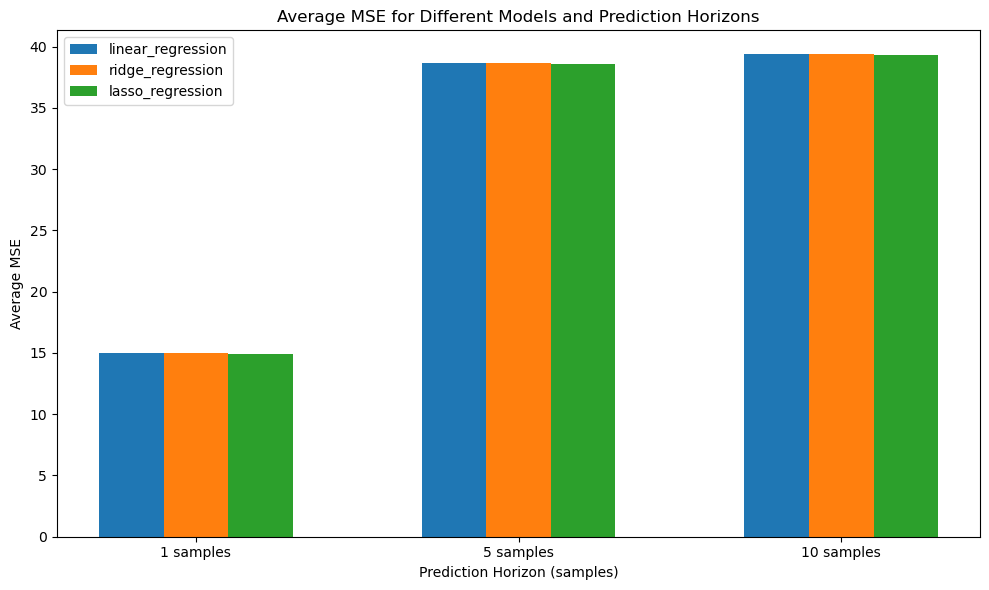

In [57]:
# Bar plot for average MSE
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(time_horizons_samples))

for i, model in enumerate(models):
    ax.bar(index + i * bar_width, results[model], bar_width, label=model)

ax.set_xlabel('Prediction Horizon (samples)')
ax.set_ylabel('Average MSE')
ax.set_title('Average MSE for Different Models and Prediction Horizons')
ax.set_xticks(index + bar_width)
ax.set_xticklabels([f'{h} samples' for h in time_horizons_samples])
ax.legend()

plt.tight_layout()
plt.show()

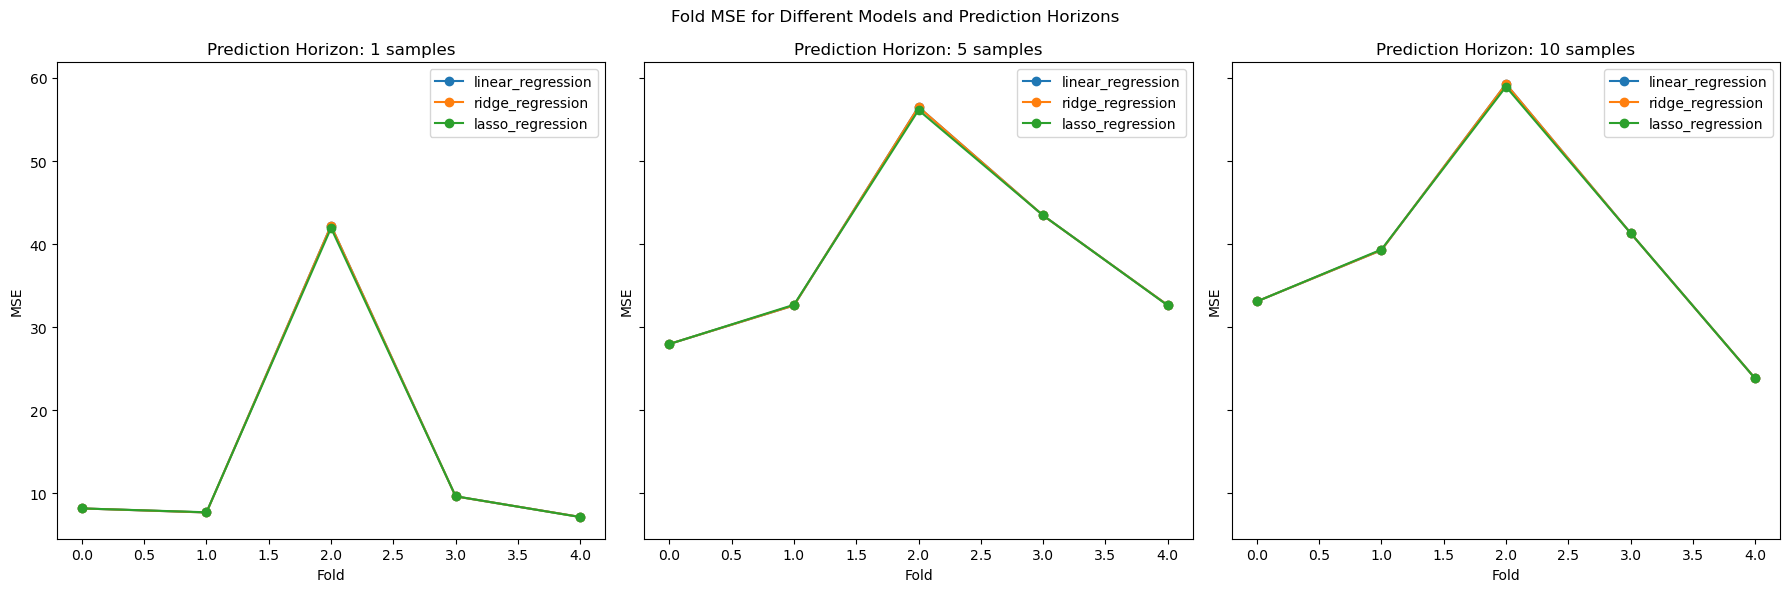

In [58]:
# Data for visualization
fold_mse = {
    "linear_regression": {
        1: [8.1975, 7.7102, 42.2357, 9.6496, 7.1729],
        5: [27.9875, 32.6203, 56.5086, 43.4534, 32.6646],
        10: [33.1059, 39.2734, 59.2691, 41.3384, 23.8471]
    },
    "ridge_regression": {
        1: [8.1975, 7.7102, 42.2357, 9.6496, 7.1729],
        5: [27.9875, 32.6203, 56.5086, 43.4534, 32.6646],
        10: [33.1059, 39.2734, 59.2691, 41.3384, 23.8471]
    },
    "lasso_regression": {
        1: [8.1974, 7.7344, 41.9390, 9.6608, 7.1584],
        5: [27.9827, 32.7017, 56.1245, 43.4596, 32.6327],
        10: [33.1009, 39.3501, 58.9397, 41.3386, 23.8360]
    }
}

# Line plot for fold MSE
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, (horizon, ax) in enumerate(zip(time_horizons_samples, axs)):
    for model in models:
        ax.plot(fold_mse[model][horizon], label=model, marker='o')
    ax.set_title(f'Prediction Horizon: {horizon} samples')
    ax.set_xlabel('Fold')
    ax.set_ylabel('MSE')
    ax.legend()

fig.suptitle('Fold MSE for Different Models and Prediction Horizons')
plt.tight_layout()
plt.show()

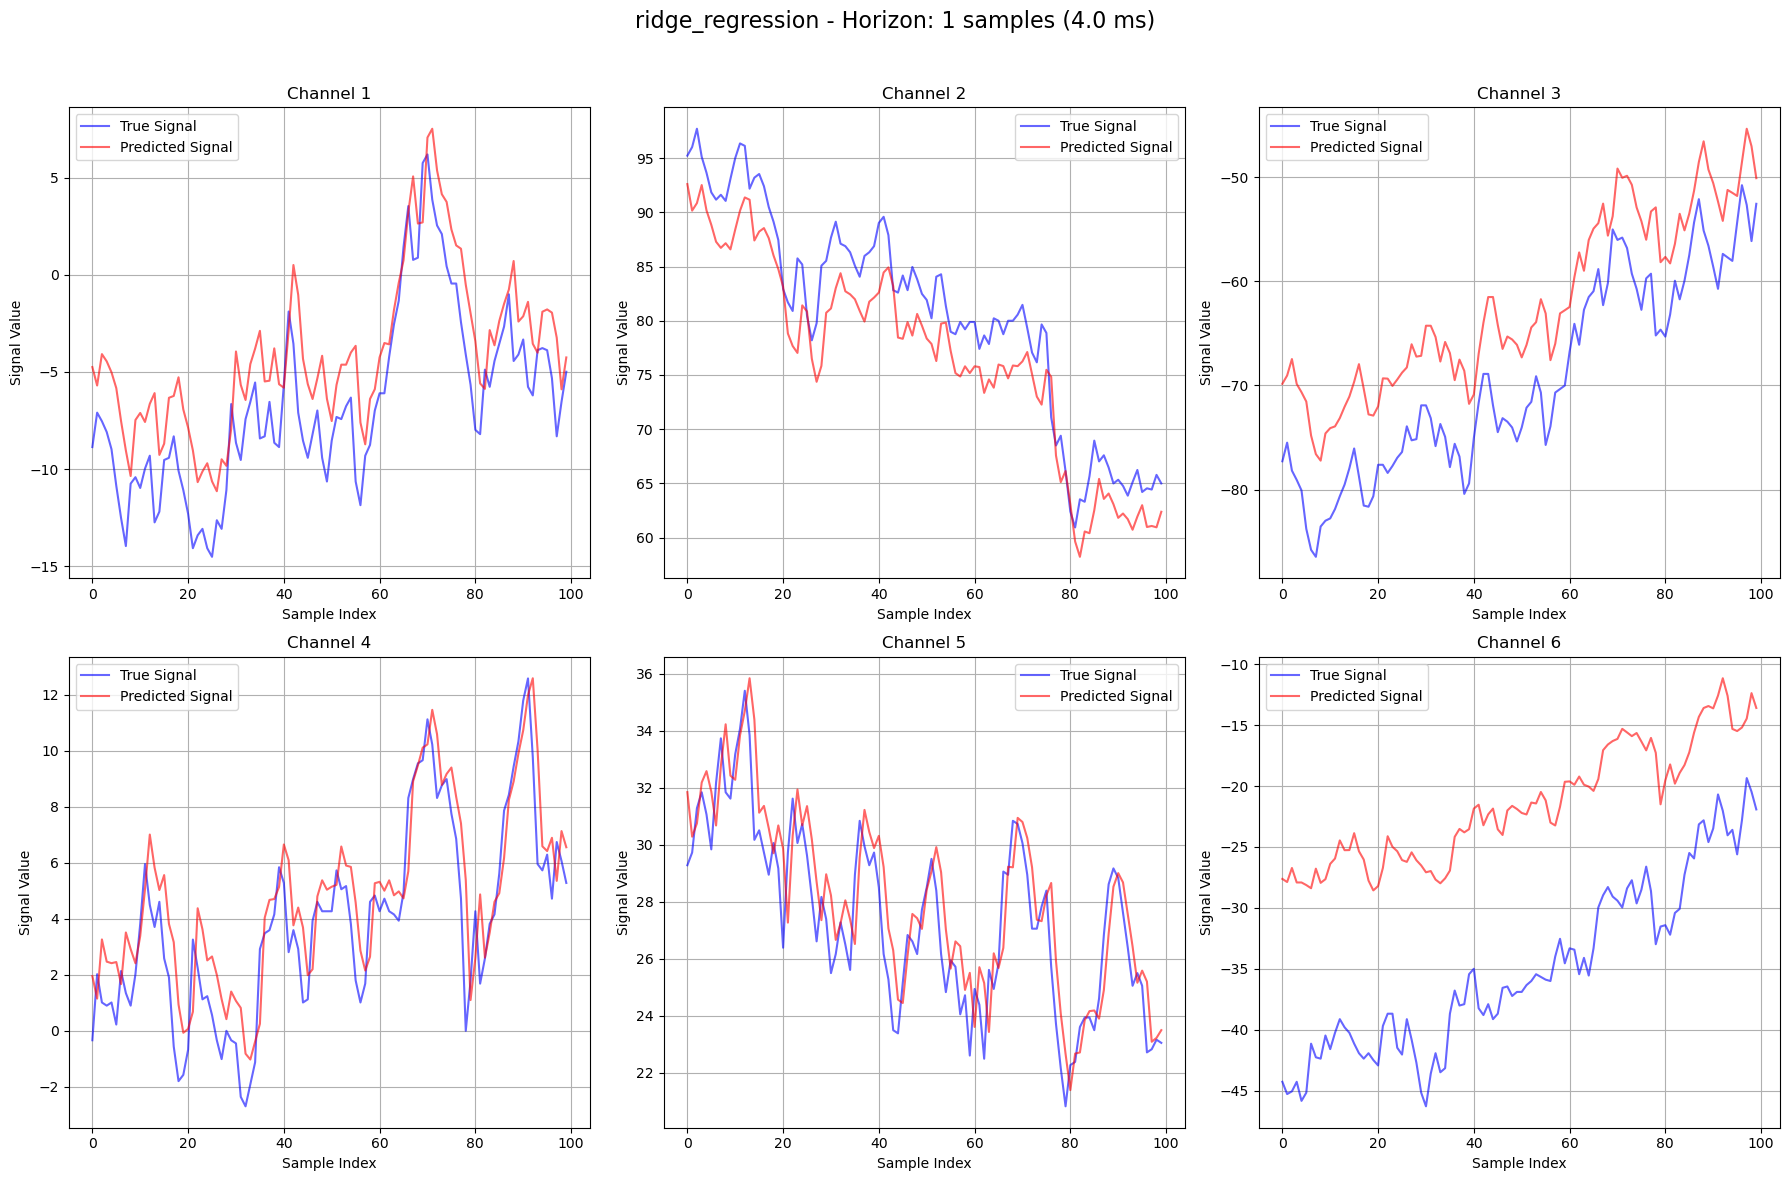

In [86]:
def visualize_best_model_predictions(all_predictions, model_name, horizon, fold, sfreq, num_samples=100):
    """
    Visualize the predictions of the best model for a given model name and horizon.
    
    Parameters:
    - all_predictions: Dictionary containing all predictions for each model
    - model_name: Name of the model to visualize
    - horizon: Horizon value to visualize
    - sfreq: Sampling frequency
    - num_samples: Number of samples to visualize
    """
    y_test, y_pred = all_predictions[model_name][horizon][fold]
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows and 3 columns for 6 channels
    fig.suptitle(f'{model_name} - Horizon: {horizon} samples ({horizon / sfreq * 1000} ms)', fontsize=16)
    
    for ch in range(y_test.shape[1]):
        row = ch // 3
        col = ch % 3
        axs[row, col].plot(y_test[:num_samples, ch], label='True Signal', color='blue', alpha=0.6)
        axs[row, col].plot(y_pred[:num_samples, ch], label='Predicted Signal', color='red', alpha=0.6)
        axs[row, col].set_xlabel('Sample Index')
        axs[row, col].set_ylabel('Signal Value')
        axs[row, col].set_title(f'Channel {ch + 1}')
        axs[row, col].legend()
        axs[row, col].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage
visualize_best_model_predictions(
    all_predictions=all_predictions,
    model_name="ridge_regression",
    horizon=time_horizons_samples[0],
    fold=1,
    sfreq=sfreq,
    num_samples=100
)


In [20]:
y_test.shape, y_pred.shape
# print("y_test:", y_test[:3, 0])  # Check the first 10 test samples
# print("y_pred:", y_pred[:3, 0])  # Check the first 10 predictions

((122279, 6), (122279, 6))

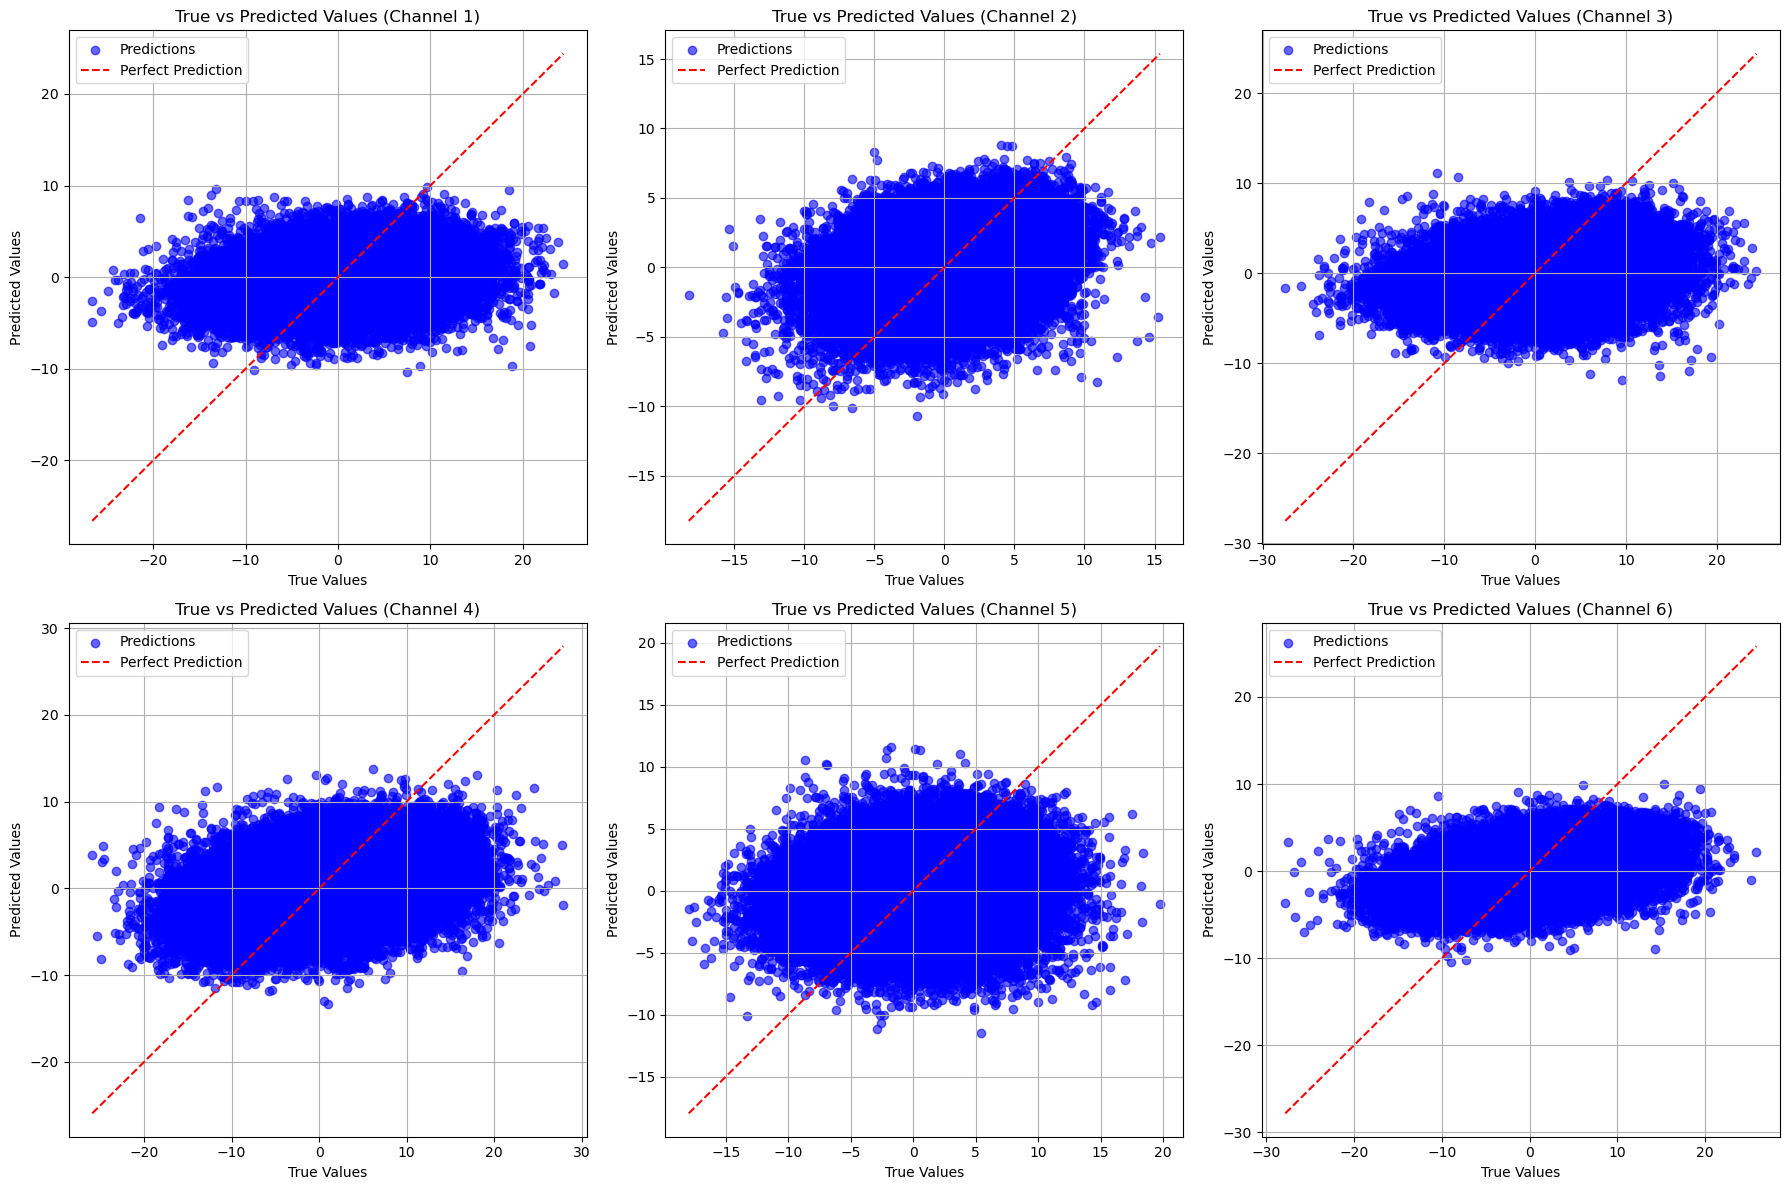

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(y_true, y_pred):
    """
    Visualize predictions by plotting predicted vs. true values.
    
    Parameters:
    - y_true: Ground truth values
    - y_pred: Predicted values
    """
    n_channels = y_true.shape[1]
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows and 3 columns
    
    for ch in range(n_channels):
        row = ch // 3
        col = ch % 3
        axs[row, col].scatter(y_true[:, ch], y_pred[:, ch], color='blue', alpha=0.6, label="Predictions")
        axs[row, col].plot([min(y_true[:, ch]), max(y_true[:, ch])], [min(y_true[:, ch]), max(y_true[:, ch])], color='red', linestyle='--', label="Perfect Prediction")
        axs[row, col].set_xlabel('True Values')
        axs[row, col].set_ylabel('Predicted Values')
        axs[row, col].set_title(f'True vs Predicted Values (Channel {ch + 1})')
        axs[row, col].legend(loc='upper left')
        axs[row, col].grid(True)
    
    plt.tight_layout()
    plt.show()
    
visualize_predictions(y_test, y_pred)

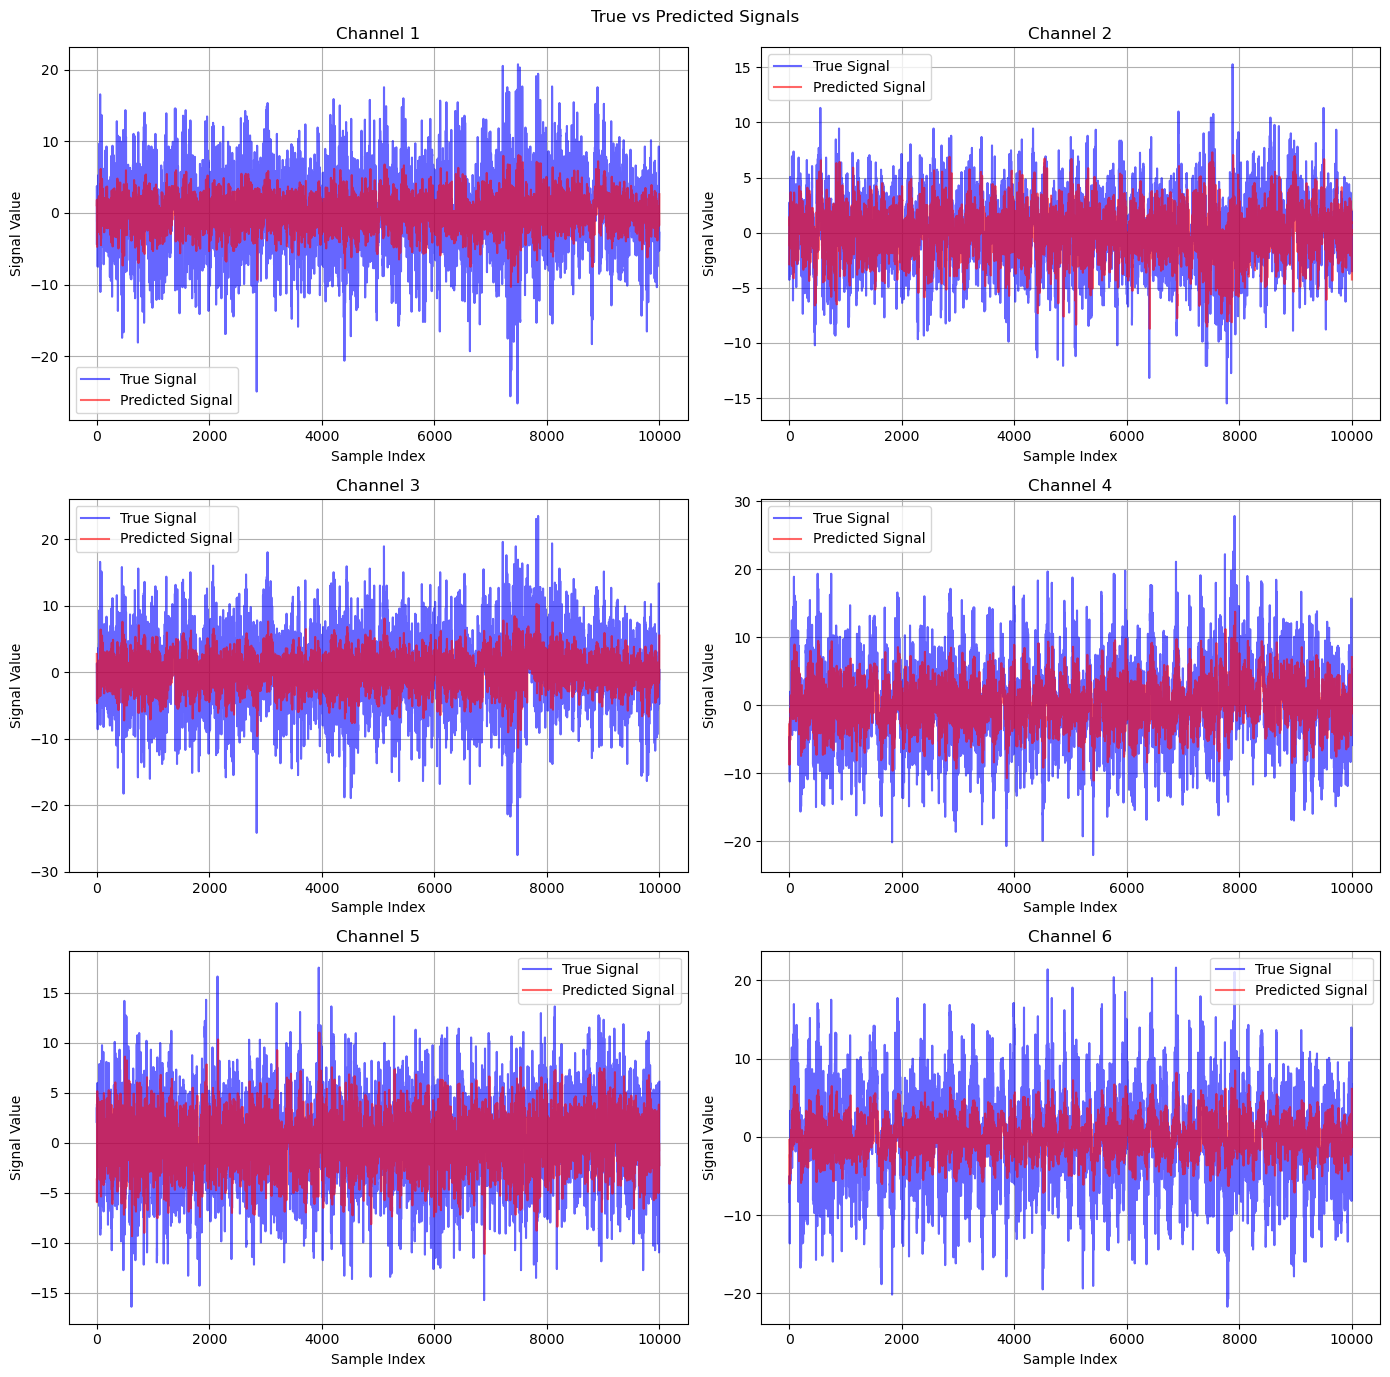

In [13]:
import matplotlib.pyplot as plt

def plot_signals(y_true, y_pred, title="True vs Predicted Signals"):
    """
    Plot the true and predicted signals for each channel.
    
    Parameters:
    - y_true: Ground truth values
    - y_pred: Predicted values
    - title: Title of the plot
    """
    n_channels = y_true.shape[1]
    fig, axs = plt.subplots(3, 2, figsize=(14, 14))  # 3 rows and 2 columns
    
    for ch in range(n_channels):
        row = ch // 2
        col = ch % 2
        axs[row, col].plot(y_true[:, ch], label='True Signal', color='blue', alpha=0.6)
        axs[row, col].plot(y_pred[:, ch], label='Predicted Signal', color='red', alpha=0.6)
        axs[row, col].set_xlabel('Sample Index')
        axs[row, col].set_ylabel('Signal Value')
        axs[row, col].set_title(f'Channel {ch + 1}')
        axs[row, col].legend()
        axs[row, col].grid(True)
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot the true and predicted signals for all channels
plot_signals(y_test[:10000], y_pred[:10000])

In [14]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from sklearn.metrics import confusion_matrix, accuracy_score

# def visualize_predictions(y_true, y_pred, fold=None):
#     """
#     Visualize and compare predictions with true labels.
    
#     Args:
#     - y_true: True labels
#     - y_pred: Predicted labels
#     - fold: (optional) Current fold number, for cross-validation context
#     """
#     # Confusion Matrix
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     title = f"Confusion Matrix for Fold {fold}" if fold else "Confusion Matrix"
#     plt.title(title)
#     plt.show()

#     # Distribution of Predictions
#     plt.figure(figsize=(8, 4))
#     sns.histplot(y_pred, color="blue", alpha=0.6, kde=True, label="Predicted")
#     sns.histplot(y_true, color="green", alpha=0.6, kde=True, label="True")
#     plt.xlabel("Class Labels")
#     plt.legend()
#     title = f"Prediction Distribution for Fold {fold}" if fold else "Prediction Distribution"
#     plt.title(title)
#     plt.show()

#     # Plot Actual vs. Predicted Labels
#     plt.figure(figsize=(10, 6))
#     plt.plot(y_true, label="True Labels", marker='o', linestyle='')
#     plt.plot(y_pred, label="Predicted Labels", marker='x', linestyle='')
#     plt.xlabel("Sample Index")
#     plt.ylabel("Class Label")
#     plt.legend()
#     title = f"Actual vs. Predicted Labels for Fold {fold}" if fold else "Actual vs. Predicted Labels"
#     plt.title(title)
#     plt.show()

# # Example usage in cross-validation loop
# from sklearn.model_selection import StratifiedKFold

# # Assuming X, y are your features and labels
# n_splits = 5
# kf = StratifiedKFold(n_splits=n_splits)

# accuracies = []

# for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
#     # Split data
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     # Train model and get predictions
#     model = LogisticRegressionModel()  # Example model
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     # Calculate accuracy
#     accuracy = accuracy_score(y_test, y_pred)
#     accuracies.append(accuracy)
#     print(f"Fold {fold} - Accuracy: {accuracy:.2f}")

#     # Visualize predictions for the current fold
#     visualize_predictions(y_test, y_pred, fold=fold)

# # Plot Accuracy Over Folds
# plt.figure(figsize=(8, 4))
# plt.plot(range(1, n_splits + 1), accuracies, marker='o')
# plt.title("Model Accuracy Across Folds")
# plt.xlabel("Fold")
# plt.ylabel("Accuracy")
# plt.xticks(range(1, n_splits + 1))
# plt.show()

In [15]:
from gait_modulation.models.base_model import LSTMModel

# Create model instances
lstm_model = LSTMModel()

# Evaluate the model using cross-validation
# splits: X_train, X_test, y_train, y_test
lstm_model.evaluate(splits, len(freq_bands))
# After cross-validation, retrain on the best evaluation split (zero's split) : fit(X_train, y_train)
# lstm_model.fit(splits[0][0], splits[0][2])

# prediction on test data: predict(X_test)
y_pred = lstm_model.predict(splits[0][1])
print("GT:", splits[0][3])
print("Predictions:", y_pred)

# plt.scatter(np.arange(splits[0][3].shape[0]), splits[0][3])
# plt.scatter(np.arange(y_pred.shape[0]), y_pred)

ImportError: cannot import name 'LSTMModel' from 'gait_modulation.models.base_model' (/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gait_modulation/gait_modulation/models/base_model.py)

In [ ]:
# If you want to do it for another model, like LSTM:



# LogisticRegression

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.preprocessing import StandardScaler

def train_logistic_regression_cv(data, labels, n_splits=5, max_iter=2000):
    """
    Trains logistic regression with cross-validation on data with arbitrary shape.
    Data is reshaped and scaled if needed. Returns models trained on each fold.
    """
    # Flatten and scale data
    if data.ndim > 2:
        data = data.reshape(data.shape[0], -1)
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # Initialize the model and cross-validation
    models = []
    indices = []
    kf = StratifiedKFold(n_splits=n_splits)
    
    for train_index, test_index in kf.split(data, labels):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        model = LogisticRegression(max_iter=max_iter)
        model.fit(X_train, y_train)
        
        models.append(model)
        indices.append((train_index, test_index))
        
    return models, indices


def evaluate_models(models, data, labels, indices):
    """
    Evaluates trained models on specified test data splits, and calculates metrics.

    Parameters:
    - models (list): List of trained models for each fold.
    - data (np.ndarray): The input data, flattened if necessary.
    - labels (np.ndarray): True labels.
    - indices (list): List of (train_index, test_index) tuples for each fold.

    Returns:
    - metrics (dict): Dictionary with metrics.
    """
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }

    # Evaluate each model
    for model, (train_index, test_index) in zip(models, indices):
        X_test = data[test_index]
        y_test = labels[test_index]
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate and store metrics
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, average='weighted'))
        metrics['recall'].append(recall_score(y_test, y_pred, average='weighted'))
        metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))
        metrics['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
    
    # Print metrics
    for key, values in metrics.items():
        if key != 'confusion_matrices':
            print(f"{key.capitalize()} - Mean: {np.mean(values):.2f}, Std: {np.std(values):.2f}")
        else:
            for i, cm in enumerate(values):
                print(f"Confusion Matrix for fold {i + 1}:\n{cm}\n")
    
    return metrics


In [ ]:
# Train models with cross-validation

# # The evaluation function remains the same as before
# models, indices = train_logistic_regression_with_cv(combined_psds_bandPower, labels)

# # Evaluate trained models
# metrics = evaluate_models(models, combined_psds_bandPower, labels, indices)



In [ ]:
epochs.get_data().shape

In [ ]:
logistic_model.evaluate(combined_psds_bandPower2.reshape(combined_psds_bandPower2.shape[0], -1), labels2)


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
import tensorflow.keras.backend as K

# Initialize metrics dictionary
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

# Reshape combined_data for LSTM input
# Reshape into (n_samples, time_steps, n_features)
# Here, we treat the whole feature set as a single time step.
X_reshaped = combined_psds_bandPower.reshape(combined_psds_bandPower.shape[0],
                                             1, 
                                             combined_psds_bandPower.shape[1])

# Generate labels
labels = np.concatenate((np.ones(psds_bandPower_mod_start.shape[0]),
                         np.zeros(psds_bandPower_normal_walking.shape[0])), axis=0)

def create_model(input_shape, learning_rate=0.0005):
    """
    Create and compile an LSTM model with dropout layers and focal loss.
    
    Parameters:
    - input_shape: Tuple representing the shape of the input data.
    
    Returns:
    - model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer with a reduced learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=focal_loss(gamma=2, alpha=0.25), optimizer=optimizer, metrics=['accuracy'])
    return model

def focal_loss(gamma=2., alpha=0.75):
    """
    Custom focal loss function to handle class imbalance.
    
    Parameters:
    - gamma: Focusing parameter for focal loss.
    - alpha: Balancing factor for classes.
    
    Returns:
    - focal_loss_fixed: Focal loss function
    """
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = -alpha_t * K.pow(1. - p_t, gamma) * K.log(p_t + K.epsilon())
        return K.mean(fl)
    return focal_loss_fixed

# Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5)

for train_index, test_index in kf.split(X_reshaped, labels):
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Apply SMOTE for resampling the training data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten for SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)
    X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], 1, X_train.shape[2])  # Reshape back for LSTM

    model = create_model((X_train_resampled.shape[1], X_train_resampled.shape[2]))  # (time_steps, features)
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Train the model
    class_weights = {0: 1.5, 1: 1.0}  # Increase weight for the minority class
    history = model.fit(X_train_resampled, y_train_resampled, 
                        epochs=50, 
                        batch_size=32, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping], 
                        class_weight=class_weights, 
                        verbose=0)

    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Threshold at 0.5 for binary classification
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred, zero_division=1))
    metrics['recall'].append(recall_score(y_test, y_pred, zero_division=1))
    metrics['f1'].append(f1_score(y_test, y_pred, zero_division=1))
    metrics['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

# Print results
for key in metrics:
    if key != 'confusion_matrices':
        print(f"{key.capitalize()} - Mean: {np.mean(metrics[key]):.2f}, Std: {np.std(metrics[key]):.2f}")
    else:
        for i, cm in enumerate(metrics['confusion_matrices']):
            print(f"Confusion Matrix for fold {i + 1}:\n{cm}\n")


In [ ]:
np.unique(labels, return_counts=True)[1], np.unique(y_train_resampled, return_counts=True)[1]

# Grid search: hyperparameters
learning rate, dropout rate, and LSTM layer sizes

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Define the model function for grid search
def create_model(lstm_units=32, dropout_rate=0.2, learning_rate=0.001, l2_reg=0.001):
    model = Sequential()
    
    # First LSTM layer with regularization
    model.add(LSTM(lstm_units, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2]),
                   return_sequences=True, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with regularization
    model.add(LSTM(lstm_units // 2, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Dense output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap the model in KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# Define the parameter grid with more diverse LSTM layer sizes and L2 regularization
param_grid = {
    'lstm_units': [128],          # Different LSTM layer sizes
    'dropout_rate': [0.2],      # Different dropout rates
    'learning_rate': [0.0001],  # Different learning rates
    'l2_reg': [0.001]               # L2 regularization values
}

# Initialize Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=5)

# Use F1-score as the scoring metric
scorer = make_scorer(f1_score, average='weighted')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=kf, verbose=2)

# Perform the grid search
grid_result = grid_search.fit(X_reshaped, labels)

# Output the best parameters and best score
print("Best parameters found: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)

# Evaluate with confusion matrix
best_model = grid_result.best_estimator_.model
y_pred = (best_model.predict(X_reshaped) > 0.5).astype("int32")
conf_matrix = confusion_matrix(labels, y_pred)

print("Confusion Matrix:\n", conf_matrix)

In [ ]:
# Best parameters found:  {'dropout_rate': 0.2, 'learning_rate': 0.001, 'lstm_units': 32}
# {'dropout_rate': 0.2, 'l2_reg': 0.001, 'learning_rate': 0.0001, 'lstm_units': 128}
# Best score:  0.7191735711731744

In [ ]:
print("Grid Search Results:")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print(f"Mean: {mean:.4f} (+/- {std:.4f}) with parameters: {param}")

In [ ]:

# Combine modulation start features
print(psds_bandPower_mod_start.shape)

# Combine normal walking features
print(psds_bandPower_normal_walking.shape)

# Combine all samples
print(combined_psds_bandPower.shape)

# Generate labels
# labels = np.concatenate((np.ones(psds_bandPower_mod_start.shape[0]), np.zeros(psds_bandPower_normal_walking.shape[0])), axis=0)

# Alternativly do not flatten across the channels

In [ ]:
psds_bandPower_mod_start = np.concatenate((psds_mod_start,
                                           band_power_mod_start), axis=2)

psds_bandPower_normal_walking = np.concatenate((psds_normal_walking, 
                                                band_power_normal_walking), axis=2)

combined_psds_bandPower = np.concatenate((psds_bandPower_mod_start,
                                          psds_bandPower_normal_walking), axis=0)

# Generate labels
labels = np.concatenate((np.ones(psds_bandPower_mod_start.shape[0]),
                         np.zeros(psds_bandPower_normal_walking.shape[0])), axis=0)



from sklearn.preprocessing import StandardScaler

# Reshape the data for LSTM
X_reshaped = combined_psds_bandPower.reshape((combined_psds_bandPower.shape[0], 
                                               combined_psds_bandPower.shape[1], 
                                               combined_psds_bandPower.shape[2]))

# Check the shape after reshaping
print("X_reshaped shape:", X_reshaped.shape)  # Expected: (757, 6, 123)

# Reshape data to 2D for scaling (samples, features)
X_reshaped_2d = X_reshaped.reshape(-1, X_reshaped.shape[-1])

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped_2d)

# Reshape back to 3D
X_scaled = X_scaled.reshape(X_reshaped.shape)

print("X_scaled shape:", X_scaled.shape)  # Expected: (757, 6, 123)